In [ ]:
#!unzip /content/drive/MyDrive/Uno_Cards.v2-raw.voc.zip -d /content/drive/MyDrive/Uno

In [ ]:
import torch
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import glob as glob
from xml.etree import ElementTree as et
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from torchsummary import summary
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2


In [ ]:
BATCH_SIZE = 8 
RESIZE_TO = 416 
NUM_EPOCHS = 10 
NUM_WORKERS = 2
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'DEVICE: {DEVICE}')
TRAIN_DIR = '/content/drive/MyDrive/Uno/train'
VALID_DIR = '/content/drive/MyDrive/Uno/valid'
TEST_DIR = '/content/drive/MyDrive/Uno/test'
CLASSES = [
    '__background__', '11', '9', '13', '10', '6', '7', '0', '5', '4', '2', '14', 
    '8', '12', '1', '3'
]
NUM_CLASSES = len(CLASSES)
VISUALIZE_TRANSFORMED_IMAGES = True

DEVICE: cuda


In [ ]:
def collate(batch):
    return tuple(zip(*batch))

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes
        
        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/*.jpg")
        self.all_images = [image_path.split(os.path.sep)[-1] for image_path in self.image_paths]
        self.all_images = sorted(self.all_images)

    def __getitem__(self, idx):
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0
        
        annot_filename = image_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.dir_path, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        image_width = image.shape[1]
        image_height = image.shape[0]
        
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            xmin_final = (xmin/image_width)*self.width
            xmax_final = (xmax/image_width)*self.width
            ymin_final = (ymin/image_height)*self.height
            yamx_final = (ymax/image_height)*self.height
            
            boxes.append([xmin_final, ymin_final, xmax_final, yamx_final])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        if self.transforms:
            sample = self.transforms(image = image_resized,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return image_resized, target
        
    def __len__(self):
        return len(self.all_images)

In [ ]:
transform_train = A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })
transform_val = A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

In [ ]:
dataset_train = CustomDataset(TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES, transforms=transform_train)
dataset_val = CustomDataset(VALID_DIR, RESIZE_TO, RESIZE_TO, CLASSES, transforms=transform_val)
datset_test = CustomDataset(TEST_DIR, RESIZE_TO, RESIZE_TO, CLASSES, transforms=transform_val)

In [ ]:
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=collate)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate)
dataloader_test = DataLoader(datset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate)

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def create_model(num_classes):
    
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

In [ ]:
model = create_model(NUM_CLASSES).to(DEVICE)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def train(train_data_loader, model):
    print('Training')
    train_loss_list = []
    # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        losses.backward()
        optimizer.step()
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

In [ ]:
def validate(valid_data_loader, model):
    print('Validating')
    val_loss_list = []
    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

In [ ]:
def WriteTxt(path: str, content: str):
    with open(path, 'a+') as f:
        f.write(f'{content}\n')

In [ ]:
log_path = '/content/drive/MyDrive/Uno/Logs'

os.mkdir(log_path)
os.mkdir(os.path.join(log_path,'Val_loss'))
os.mkdir(os.path.join(log_path,'Train_loss'))
os.mkdir(os.path.join(log_path,'models'))

In [ ]:
train_LOSSES, val_LOSSES = [], []
for epoch in range(NUM_EPOCHS):
    tr_loss = train(dataloader_train, model)
    vl_loss = validate(dataloader_val, model)

    WriteTxt(os.path.join(os.path.join(log_path,'Train_loss'), f'{epoch}.txt'), str(tr_loss))
    WriteTxt(os.path.join(os.path.join(log_path,'Val_loss'), f'{epoch}.txt'), str(vl_loss))
    torch.save(model.state_dict(), os.path.join(os.path.join(log_path, 'models'), f'_epoch_{epoch}' + '.pt'))

    train_LOSSES.append(tr_loss)
    val_LOSSES.append(val_LOSSES)


Training


  0%|          | 0/787 [00:00<?, ?it/s]

Validating


  0%|          | 0/225 [00:00<?, ?it/s]

Training


  0%|          | 0/787 [00:00<?, ?it/s]

Validating


  0%|          | 0/225 [00:00<?, ?it/s]

Training


  0%|          | 0/787 [00:00<?, ?it/s]

Validating


  0%|          | 0/225 [00:00<?, ?it/s]

Training


  0%|          | 0/787 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f37f2c83440>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f37f2c83440>  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__

Exception ignored in: Traceback (most recent call last):
      File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f37f2c83440>    

self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
            if w.is_alive():if w.is_a

Validating


  0%|          | 0/225 [00:00<?, ?it/s]

Training


  0%|          | 0/787 [00:00<?, ?it/s]

Validating


  0%|          | 0/225 [00:00<?, ?it/s]

Training


  0%|          | 0/787 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f37f2c83440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    Exception ignored in: assert self._parent_pid == os.getpid(), 'can only test a child process'
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f37f2c83440>Exception ignored in: AssertionError
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f37f2c83440>: Traceback (most recent call last):
can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__

Traceback (most recent call last):
    Exception ignored in: self._shutdown_workers()
<functio

Validating


  0%|          | 0/225 [00:00<?, ?it/s]

Training


  0%|          | 0/787 [00:00<?, ?it/s]

Validating


  0%|          | 0/225 [00:00<?, ?it/s]

Training


  0%|          | 0/787 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f37f2c83440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f37f2c83440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Validating


  0%|          | 0/225 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f37f2c83440><function _MultiProcessingDataLoaderIter.__del__ at 0x7f37f2c83440>

Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f37f2c83440>  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):

      File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
Traceback (most recent call last):
self._shutdown_workers()
      File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
      File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
self._shutdown_workers()self._shutdown_workers()Exception ignored in: 
      File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _

Training


  0%|          | 0/787 [00:00<?, ?it/s]

Validating


  0%|          | 0/225 [00:00<?, ?it/s]

Training


  0%|          | 0/787 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f37f2c83440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f37f2c83440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Validating


  0%|          | 0/225 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f37f2c83440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f37f2c83440>

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
      File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    if w.is_alive():self._shutdown_workers()

Exception ignored in:   File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f37f2c83440>  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
        
Traceback (most recent call last):
if w.is_alive():  File "/usr/loc

In [ ]:
val_loss_path = '/content/drive/MyDrive/Uno/Logs/Val_loss'
vals_txt = os.listdir(val_loss_path)

In [ ]:
def readTxt(val_txt):
    new = []
    with open(os.path.join(val_loss_path, val_txt), 'r') as f:
        a = f.read().split(', ')
        for item in a:
            item = item.replace('[','')
            item = item.replace(']\n','')
            
            new.append(float(item))
    return new 

In [ ]:
d = {}
for val_txt in vals_txt:
    tmp = readTxt(val_txt)
    d[val_txt] = sum(tmp)/len(tmp)

In [ ]:
list(d.keys())

['0.txt',
 '1.txt',
 '2.txt',
 '3.txt',
 '4.txt',
 '5.txt',
 '6.txt',
 '7.txt',
 '8.txt',
 '9.txt']

Text(0, 0.5, 'Val loss')

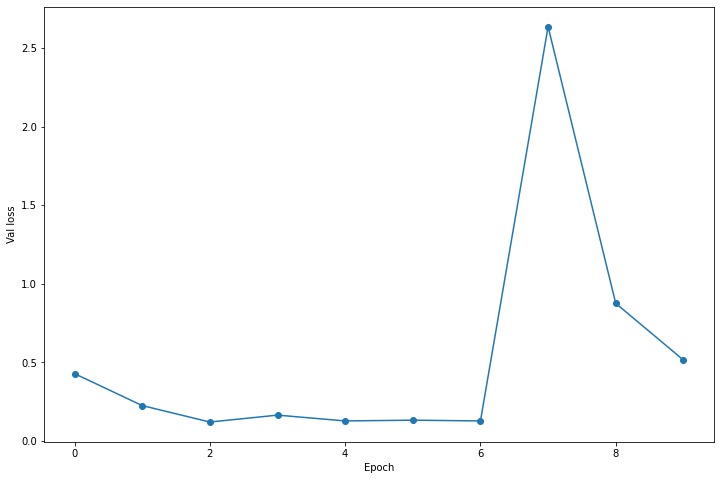

In [ ]:
plt.figure(figsize=(12,8)) 
plt.plot([int(x[0]) for x in list(d.keys())], [d[key] for key in list(d.keys())], '-o')
plt.xlabel('Epoch')
plt.ylabel('Val loss')

In [ ]:
d

{'0.txt': 0.4272189297940996,
 '1.txt': 0.2241264781686995,
 '2.txt': 0.11959580441315969,
 '3.txt': 0.16353144251637988,
 '4.txt': 0.12663153108623293,
 '5.txt': 0.13141178876161574,
 '6.txt': 0.1265607448418935,
 '7.txt': 2.6353615220387776,
 '8.txt': 0.8748479239145914,
 '9.txt': 0.5145493189493815}

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Uno/Logs/models/_epoch_2.pt'))

<All keys matched successfully>

#Перевод модели в .onnx формат

In [ ]:
model.eval()
x = datset_test[0][0].unsqueeze(0).to(DEVICE)#torch.randn(1, 3, 416, 416, requires_grad=True)
print(x.shape)
torch_out = model(x)

input_names = [ "actual_input" ]
output_names = [ "output" ]

torch.onnx.export(model, 
                  x,
                  "Uno_detector.onnx",
                  verbose=False,
                  input_names=input_names,
                  output_names=output_names,
                  export_params=True,
                  )

torch.Size([1, 3, 416, 416])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3897: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  for i in range(dim)
/usr/local/lib/python3.7/dist-packages/torchvision/models/detection/anchor_utils.py:124: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  for g in grid_sizes
/usr/local/lib/python3.7/dist-packages/torchvision/models/detection/rpn.py:99: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc'

# Inference модели в формате .onnx

In [ ]:
!pip install onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 20.3 MB/s 
     |████████████████████████████████| 46 kB 4.5 MB/s 
     |████████████████████████████████| 86 kB 6.7 MB/s 


In [ ]:
import onnxruntime as onnxrt
onnx_session= onnxrt.InferenceSession("Uno_detector.onnx")
onnx_inputs= {onnx_session.get_inputs()[0].name: x.cpu().numpy()}
onnx_output = onnx_session.run(None, input_feed=onnx_inputs)
res = {}
keys = ['boxes', 'labels', 'scores']
for idx, key in enumerate(keys):
    res[key] = onnx_output[idx]
res

{'boxes': array([[173.98074 , 115.024506, 194.70105 , 140.55203 ],
        [155.3942  , 115.68475 , 171.69478 , 140.19357 ],
        [209.15672 , 123.227806, 229.86842 , 147.82742 ],
        [209.21527 , 123.42164 , 229.73625 , 147.33487 ],
        [176.43083 , 119.98251 , 191.33093 , 136.99669 ],
        [153.1439  , 114.058014, 180.34468 , 140.23132 ],
        [154.6258  , 116.25042 , 172.93037 , 138.98349 ],
        [208.27202 , 121.86298 , 231.43494 , 147.85269 ],
        [154.5557  , 114.748245, 176.39034 , 141.34093 ],
        [153.80666 , 114.118416, 180.18011 , 139.4222  ]], dtype=float32),
 'labels': array([ 7, 14,  5,  2,  3,  6, 13,  9,  1, 11], dtype=int64),
 'scores': array([0.9861605 , 0.9229883 , 0.7265607 , 0.6990055 , 0.21026383,
        0.1940458 , 0.14337242, 0.10490771, 0.06246325, 0.05821065],
       dtype=float32)}

## Получаем придикты используя .onnx модель

In [ ]:
def GetPreds(image):
    onnx_session= onnxrt.InferenceSession("Uno_detector.onnx")
    onnx_inputs= {onnx_session.get_inputs()[0].name: image}
    onnx_output = onnx_session.run(None, input_feed=onnx_inputs)
    res = {}
    keys = ['boxes', 'labels', 'scores']
    for idx, key in enumerate(keys):
        res[key] = onnx_output[idx]
    return res

Отрисовываем результат

In [ ]:
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

image = cv2.imread('/content/uno_1.jpg')
orig_image = image.copy()
image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0
image = np.transpose(image, (2, 0, 1)).astype(np.float32)
image = np.expand_dims(image, 0)
print(image.shape)

res = GetPreds(image)

if len(res['boxes']) != 0:
    boxes = res['boxes']
    scores = res['scores']
    boxes = boxes[scores >= 0.7].astype(np.int32)
    draw_boxes = boxes.copy()
    pred_classes = [CLASSES[i] for i in res['labels']]
    
    for j, box in enumerate(draw_boxes):
        class_name = pred_classes[j]
        color = COLORS[CLASSES.index(class_name)]
        cv2.rectangle(orig_image,
                    (int(box[0]), int(box[1])),
                    (int(box[2]), int(box[3])),
                    color, 2)
        cv2.putText(orig_image, class_name, 
                    (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 
                    2, lineType=cv2.LINE_AA)
    cv2.imwrite(f"/content/uno_1_pred.jpg", orig_image)

(3, 416, 416)
(1, 3, 416, 416)
{'boxes': array([[173.98074 , 115.024506, 194.70105 , 140.55203 ],
       [155.3942  , 115.68475 , 171.69478 , 140.19357 ],
       [209.15672 , 123.227806, 229.86842 , 147.82742 ],
       [209.21527 , 123.42164 , 229.73625 , 147.33487 ],
       [176.43083 , 119.98251 , 191.33093 , 136.99669 ],
       [153.1439  , 114.058014, 180.34468 , 140.23132 ],
       [154.6258  , 116.25042 , 172.93037 , 138.98349 ],
       [208.27202 , 121.86298 , 231.43494 , 147.85269 ],
       [154.5557  , 114.748245, 176.39034 , 141.34093 ],
       [153.80666 , 114.118416, 180.18011 , 139.4222  ]], dtype=float32), 'labels': array([ 7, 14,  5,  2,  3,  6, 13,  9,  1, 11], dtype=int64), 'scores': array([0.9861605 , 0.9229883 , 0.7265607 , 0.6990055 , 0.21026383,
       0.1940458 , 0.14337242, 0.10490771, 0.06246325, 0.05821065],
      dtype=float32)}
